### Import Libraries

In [1]:
import fnmatch
import time
import os
import glob
import pandas as pd
import numpy as np
import math
import netCDF4
import csv
import rasterio
import scipy
import subprocess
import richdem as rd
#from osgeo import gdal
#from osgeo import osr
import skimage.io as io
import xarray as xr
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.io import netcdf 
from scipy.ndimage import gaussian_filter
from netCDF4 import Dataset
from collections import OrderedDict
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, OPTICS, SpectralClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
import geopandas as gpd

### Set Directory and Get List of Files

In [2]:
# Path to Version 3 directory
V3_path  = "./data/ABoVE_ReSALT_InSAR_PolSAR_V3_2004/data/"
out_path = './output/'

print("Path to V3 Files: ", V3_path)

# get all files in the directory
#dir_tree = os.walk(V3_path)
#for dirpath, dirnames, filenames in dir_tree:
#    pass
filenames = os.listdir(V3_path)


# find all the netcdf V3 files
print('Version 3 Files:')
file_list = []
num_files = 0
for file in filenames:
    print(file)
    if file.endswith('.nc4'):
        file_list.append(file)
        num_files=num_files+1
        print(num_files,file)

print('Total Number of V3 Files: ', num_files)
print('Done!')

Path to V3 Files:  ./data/ABoVE_ReSALT_InSAR_PolSAR_V3_2004/data/
Version 3 Files:
PDO_ReSALT_chevak_2017_03.nc4
1 PDO_ReSALT_chevak_2017_03.nc4
PDO_ReSALT_denali_2017_03.nc4
2 PDO_ReSALT_denali_2017_03.nc4
PDO_ReSALT_nwells_2017_03_qa_exent_ArcticDEM_mosaic_crop_prj.tif
PDO_ReSALT_kougar_2017_03.nc4
3 PDO_ReSALT_kougar_2017_03.nc4
PDO_ReSALT_koyukk_2017_03_qa_exent_ArcticDEM_mosaic_crop_prj.tif
PDO_ReSALT_snagyk_2017_03_qa_exent_ArcticDEM_mosaic_crop_prj.tif
PDO_ReSALT_behcho_2017_03_qa_exent_ArcticDEM_mosaic_crop_prj.tif
PDO_ReSALT_noatak_2017_03.nc4
4 PDO_ReSALT_noatak_2017_03.nc4
PDO_ReSALT_lclark_2017_03.nc4
5 PDO_ReSALT_lclark_2017_03.nc4
PDO_ReSALT_deltaj_2017_03_qa_exent_ArcticDEM_mosaic_crop_prj.tif
PDO_ReSALT_gdhope_2017_03.nc4
6 PDO_ReSALT_gdhope_2017_03.nc4
PDO_ReSALT_dhorse_2017_03.nc4
7 PDO_ReSALT_dhorse_2017_03.nc4
PDO_ReSALT_ambler_2017_03_qa_exent_ArcticDEM_mosaic_crop_prj.tif
PDO_ReSALT_oldcrB_2017_03.nc4
8 PDO_ReSALT_oldcrB_2017_03.nc4
PDO_ReSALT_wriglN_2017_03.nc4
9

### Define a bunch of functions

In [3]:
def read_pdo_version_3_netcdf_file(filename, print_flag):
    # this function reads data from standard PDO version 3 data file

    # open netcdf file
    ncfile = Dataset(filename)
    
    # check if file has vwc data because not all swaths have VWC
    has_vwc=False
    for var in ncfile.variables.keys():
        if (var == 'mv_alt'):
            has_vwc = True

    # read the variables
    nc_alt = ncfile.variables['alt']
    nc_sub = ncfile.variables['sub']
    if has_vwc:
        nc_vwc_12 = ncfile.variables['mv_12cm']
        nc_vwc_20 = ncfile.variables['mv_20cm']
        nc_vwc_alt = ncfile.variables['mv_alt']
        nc_wtd = ncfile.variables['wtd']
    nc_lon = ncfile.variables['lon']
    nc_lat = ncfile.variables['lat']

    # determine dimensions of swath
    nscan_loc, nspot_loc = nc_alt.shape
    numpt_loc  = nscan_loc*nspot_loc  # total number of points
    
    # allocate output arrays
    # '_loc' means local to this function
    alt_loc = np.zeros((numpt_loc))
    sub_loc = np.zeros((numpt_loc))
    vwc_12_loc  = np.zeros((numpt_loc))
    vwc_20_loc  = np.zeros((numpt_loc))
    vwc_alt_loc = np.zeros((numpt_loc))
    wtd_loc = np.zeros((numpt_loc))
    lon_loc = np.zeros((numpt_loc))
    lat_loc = np.zeros((numpt_loc))

    # reshape arrays from 2D swath to 1D vector
    # vectors are much easier to handle, especially for statistics
    alt_loc = np.array(nc_alt[:,:]).reshape(-1)
    sub_loc = np.array(nc_sub[:,:]).reshape(-1)
    if has_vwc:
        vwc_12_loc  = np.array(nc_vwc_12[:,:]).reshape(-1)
        vwc_20_loc  = np.array(nc_vwc_20[:,:]).reshape(-1)
        vwc_alt_loc = np.array(nc_vwc_alt[:,:]).reshape(-1)
        wtd_loc     = np.array(nc_wtd[:,:]).reshape(-1)
    if not has_vwc:
        vwc_12_loc  = -9999.
        vwc_20_loc  = -9999.
        vwc_alt_loc = -9999.
        wtd_loc     = -9999.
    lon_loc = np.array(nc_lon[:,:]).reshape(-1)
    lat_loc = np.array(nc_lat[:,:]).reshape(-1)

    # close netcdf file
    ncfile.close()
    
    # Print stuff, if desired
    if(print_flag):
        print(' ')
        print('Read Filename: ', filename)
        print('nscan: ', nscan_loc)
        print('nspot: ', nspot_loc)
        print('numpt: ', numpt_loc)
        print('lon min: ', min(lon_loc), ' max: ', max(lon_loc))
        print('lat min: ', min(lat_loc), ' max: ', max(lat_loc))
        print('ALT min: ', min(alt_loc), ' max: ', max(alt_loc))
        print('sub min: ', min(sub_loc), ' max: ', max(sub_loc))
        if has_vwc:
            print('vwc 12 min: ',  min(vwc_12_loc),  ' max: ', max(vwc_12_loc))
            print('vwc 20 min: ',  min(vwc_20_loc),  ' max: ', max(vwc_20_loc))
            print('vwc alt min: ', min(vwc_alt_loc), ' max: ', max(vwc_alt_loc))
            print('wtd min: ',     min(wtd_loc),     ' max: ', max(wtd_loc))

    return nscan_loc, nspot_loc, alt_loc, sub_loc, vwc_12_loc, vwc_20_loc, vwc_alt_loc, wtd_loc, lon_loc, lat_loc, has_vwc
# def read_pdo_version_3_netcdf_file(filename, print_flag):
#     # this function reads data from standard PDO version 3 data file

#     # open netcdf file
#     ncfile = Dataset(filename) # Dataset is a function that's part of the netCDF4 library
    
#     # check if file has vwc data because not all swaths have VWC
#     has_vwc=False
#     for var in ncfile.variables.keys():
#         if (var == 'mv_alt'):
#             has_vwc = True

#     # read the variables
#     nc_alt = ncfile.variables['alt']
#     nc_sub = ncfile.variables['sub'] # subsidence
#     if has_vwc:
#         nc_vwc = ncfile.variables['mv_alt'] # vwc if has
#     nc_lon = ncfile.variables['lon'] # array with longitude at each point, 2D
#     nc_lat = ncfile.variables['lat']

#     # determine dimensions of swath
#     nscan_loc, nspot_loc = nc_alt.shape
#     numpt_loc  = nscan_loc*nspot_loc  # total number of points
    
#     # allocate output arrays
#     # '_loc' means local to this function
#     alt_loc = np.zeros((numpt_loc))
#     sub_loc = np.zeros((numpt_loc))
#     vwc_loc = np.zeros((numpt_loc))
#     lon_loc = np.zeros((numpt_loc))
#     lat_loc = np.zeros((numpt_loc))

#     # reshape arrays from 2D swath to 1D vector
#     # vectors are much easier to handle, especially for statistics
#     alt_loc = np.array(nc_alt[:,:]).reshape(-1)
#     sub_loc = np.array(nc_sub[:,:]).reshape(-1)
#     if has_vwc:
#         vwc_loc = np.array(nc_vwc[:,:]).reshape(-1)
#     lon_loc = np.array(nc_lon[:,:]).reshape(-1)
#     lat_loc = np.array(nc_lat[:,:]).reshape(-1)

#     # close netcdf file
#     ncfile.close()
    
#     # Print stuff, if desired
#     if(print_flag):
#         print(' ')
#         print('Read Filename: ', filename)
#         print('nscan: ', nscan_loc)
#         print('nspot: ', nspot_loc)
#         print('numpt: ', numpt_loc)
#         print('lon min: ', min(lon_loc), ' max: ', max(lon_loc))
#         print('lat min: ', min(lat_loc), ' max: ', max(lat_loc))
#         print('ALT min: ', min(alt_loc), ' max: ', max(alt_loc))
#         print('sub min: ', min(sub_loc), ' sub: ', max(sub_loc))
#         print('vwc min: ', min(vwc_loc), ' sub: ', max(vwc_loc))

#     return nscan_loc, nspot_loc, alt_loc, sub_loc, vwc_loc, lon_loc, lat_loc, has_vwc

def vector_statistics_row(vector, swath, var, units, print_header):
    # calculates statistics of vector
    # prints standard statistics as a table
    # assumes all missing values removed from vector
    
    # Table header
    head = []
    head.append("Swath")
    head.append("Var")
    head.append("Units")
    head.append("Num")
    head.append("Ave")
    head.append("Std")
    head.append("Min")
    head.append("5%")
    head.append("25%")
    head.append("Med")
    head.append("75%")
    head.append("95%")
    head.append("Max")

    # calculate statistics
    stats=np.zeros((10))
    stats[0]=len(vector)              # total number of points in vector
    stats[1]=np.mean(vector)          # mean
    stats[2]=np.std(vector)           # standard deviation
    stats[3]=min(vector)              # minimum value
    stats[4]=np.percentile(vector,5)  # 5th percentile
    stats[5]=np.percentile(vector,25) # 25th percentile
    stats[6]=np.median(vector)        # median
    stats[7]=np.percentile(vector,75) # 75th percentile
    stats[8]=np.percentile(vector,95) # 95th percentile
    stats[9]=max(vector)              # maximum value

    # Print table header
    if (print_header):
        print(f'{head[0]:>10}', f'{head[1]:>4}', f'{head[2]:>4}', f'{head[3]:>7}', f'{head[4]:>7}', f'{head[5]:>7}', f'{head[6]:>7}', \
              f'{head[7]:>7}', f'{head[8]:>7}', f'{head[9]:>7}', f'{head[10]:>7}', f'{head[11]:>7}', f'{head[12]:>10}')
    print(f'{swath[0:10]:>10}',f'{var[0:4]:>4}', f'{units[0:4]:>4}',f'{stats[0]:7.0f}', f'{stats[1]:7.4f}', f'{stats[2]:7.4f}', \
          f'{stats[3]:7.4f}', f'{stats[4]:7.4f}', f'{stats[5]:7.4f}', f'{stats[6]:7.4f}', f'{stats[7]:7.4f}', \
          f'{stats[8]:7.4f}', f'{stats[9]:7.4f}' )

    return

def append_vector2_to_end_of_vector1(vector1, vector2, missing, print_flag):
    # Appends vector2 on the end of vector1
    # returns updated vector1
    
    # lenth of updated vector
    vec1_len = len(vector1) # number of points vector1
    vec2_len = len(vector2) # number of points vector2
    vec1_len_new = vec1_len + vec2_len

    # new vector1
    vec1_new = np.zeros((vec1_len_new))

    # loop through vector2
    count=0  # number of valid value pairs
    for ipt in range(vec2_len):
        count = vec1_len + ipt
        vec1_new[count] = vector2[ipt]

    if (print_flag):
        print('New Vector length: ', vec1_len_new)
    
    return vec1_len_new, vec1_new

def match_two_vectors(vector1, vector2, missing, print_flag):
    # identifies all valid matching pairs of values between vector1 and vector2
    # valid means both vectors not equal to missing
    # returns two vectors containing only valid matching value pairs
    # assumes both vectors have the same length
    
    # define local variables
    vec_len = len(vector1)          # number of points
    vec1_temp = np.zeros((vec_len)) # temporary holding vector
    vec2_temp = np.zeros((vec_len)) # temporary holding vector

    # loop through vector
    count=0  # number of valid value pairs
    for ipt in range(vec_len):
        if (vector1[ipt] != missing and vector2[ipt] != missing ):
            vec1_temp[count] = vector1[ipt]
            vec2_temp[count] = vector2[ipt]
            count = count+1

    if (print_flag):
        print('match_two_vectors num pts before filter: ', vec_len)
        print('match_two_vectors num valid pairs: ', count)
    
    # output filtered vvalid pairs
    vec1_filt = np.zeros((count))
    vec2_filt = np.zeros((count))
    vec1_filt = vec1_temp[0:count]
    vec2_filt = vec2_temp[0:count]
    
    return count, vec1_filt, vec2_filt

def Filter_vector(vector, missing, print_flag):
    # filters out all missing values in vector
    # returns a vector containing only valid values
    
    # define local variables
    vec_len = len(vector)          # number of points
    vec_temp = np.zeros((vec_len)) # temporary holding vector

    # loop through vector
    count=0  # number of valid values
    for ipt in range(vec_len):
        if (vector[ipt] != missing):
            vec_temp[count] = vector[ipt]
            count = count+1

    if (print_flag):
        print('Filter_vector num pts before filter: ', vec_len)
        print('Filter_vector num pts after filter: ', count)
    
    # output filtered vector
    vec_filt = np.zeros((count))
    vec_filt = vec_temp[0:count]
    
    return count, vec_filt

def histogram_plot(vector, title, xlabel, bmin, bmax, bdelta, filename, display):
    # calculates histogram of vector
    color = []
    color.append("black")
    N, bins, patches = plt.hist(vector, bins=np.arange(bmin, 1.01*bmax, step=bdelta), range=[bmin,bmax], density=True, color=color[0])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Percent")
    plt.savefig(filename)
    if display:
        plt.show()
    plt.close()

def dual_histogram_plot(vector1, vector2, vector3, bmin, bmax, bdelta, title, xlabel, labels, legend, filename, display):
    # plots three histograms on same plot
    color = []
    color.append("black")
    color.append("red")
    color.append("blue")
    color.append("green")
    color.append("magenta")
    plt.hist(vector1, bins=np.arange(bmin, 1.01*bmax, step=bdelta), range=[bmin,bmax], label=labels[0], density=True, histtype = 'step', color=color[0])
    plt.hist(vector2, bins=np.arange(bmin, 1.01*bmax, step=bdelta), range=[bmin,bmax], label=labels[1], density=True, histtype = 'step', color=color[1])
    plt.hist(vector3, bins=np.arange(bmin, 1.01*bmax, step=bdelta), range=[bmin,bmax], label=labels[2], density=True, histtype = 'step', color=color[2])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Percent")
    plt.legend(loc=legend)
    plt.savefig(filename)
    if display:
        plt.show()
    plt.close()

def plot_scatter(xval, yval, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, filename, display):
    # creats XY scatter plot
    color = []
    color.append("black")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.xticks(np.arange(xmin, 1.01*xmax, step=deltax))
    plt.yticks(np.arange(ymin, 1.001*ymax, step=deltay))
    plt.scatter(xval, yval, s = 1, color=color[0])
    plt.grid(True)
    plt.savefig(filename)
    if display:
        plt.show()
    plt.close()

def plot_scatter_two(xval1, yval1, xval2, yval2, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, labels, legend, filename, display):
    # creates XY scatter plot of two sets of variables
    color = []
    color.append("black")
    color.append("red")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.xticks(np.arange(xmin, 1.01*xmax, step=deltax))
    plt.yticks(np.arange(ymin, 1.001*ymax, step=deltay))
    plt.scatter(xval1, yval1, s = 1, color=color[0], label=labels[0])
    plt.scatter(xval2, yval2, s = 1, color=color[1], label=labels[1])
    plt.grid(True)
    plt.legend(loc=legend)
    plt.savefig(filename)
    if display:
        plt.show()
    plt.close()

def plot_lines(line, numcol, xmin,xmax, deltax, ymin,ymax, deltay,labx, laby, title, labels, legend, filename):
    # plots numcol lines on a single plot
    color = []
    color.append("black")
    color.append("red")
    color.append("blue")
    color.append("green")
    color.append("magenta")
    color.append("orange")
    color.append("turquoise")
    color.append("lime")
    color.append("purple")
    color.append("tomato")
    color.append("gold")
    plt.xlabel(labx)
    plt.ylabel(laby)
    plt.title(title)
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.xticks(np.arange(xmin, 1.001*xmax, step=deltax))
    plt.yticks(np.arange(ymin, 1.00001*ymax, step=deltay))
    for ilin in range(1,numcol):
        if ilin != 50:
            plt.plot(line[:, 0],line[:, ilin], color=color[ilin-1], label=labels[ilin-1])
        if ilin == 50:
            plt.scatter(line[:, 0], line[:, ilin], s = 1, color=color[ilin-1], label=labels[ilin-1])
    plt.grid(True)
    plt.legend(loc=legend)
    plt.savefig(filename)
    plt.show()

def plot_contour(xval, yval, zval, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac, labx, laby, labcon, title, filename):
    # creates a contour plot
    plt.xlabel(labx)
    plt.ylabel(laby)
    plt.title(title)
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.xticks(np.arange(xmin, 1.001*xmax, step=deltax))
    plt.yticks(np.arange(ymin, 1.001*ymax, step=deltay))
    levels = (np.arange(cmin, 1.001*cmax, step=deltac))
    cont = plt.contourf(xval, yval, zval, levels=levels)
    cbar = plt.colorbar(cont)
    cbar.ax.set_ylabel(labcon)
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def histo_2d_pdf(vector1, vector2, xvec, yvec, pdf, print_flag, name):
    # identifies all valid matching pairs of values between vector1 and vector2
    # counts them in 2-dimensional pdf
    # valid means both vectors not equal to missing
    # returns updated pdf
    # assumes both vectors have the same length
    
    # define local variables
    vec_len = len(vector1) # number of points
    numpts_xvec = len(xvec)
    numpts_yvec = len(yvec)
    xmin = min(xvec)
    ymin = min(yvec)
    xmax = max(xvec)
    ymax = max(yvec)
    pdf_temp       = np.zeros((numpts_xvec,numpts_yvec))
    stuff = np.histogram2d(vector1, vector2, bins=numpts_xvec, range=[[xmin, xmax], [ymin, ymax]])
    pdf_temp = stuff[0]
    pdf = pdf +np.transpose(pdf_temp)

    if (print_flag):
        count = np.sum(pdf_temp)
        print('pdf ',name,' num valid pairs: ', count)
    
    return pdf
    
    
    
def farm_to_2d_pdf(vector1, vector2, xvec, yvec, pdf, missing, print_flag):
    # identifies all valid matching pairs of values between vector1 and vector2
    # counts them in 2-dimensional pdf
    # valid means both vectors not equal to missing
    # returns updated pdf
    # assumes both vectors have the same length
    
    # define local variables
    vec_len = len(vector1) # number of points
    numpts_xvec = len(xvec)
    numpts_yvec = len(yvec)
    x_min = xvec[0]
    y_min = yvec[0]
    delta_x = xvec[1] - xvec[0]
    delta_y = yvec[1] - yvec[0]

    # loop through vector
    count=0  # number of valid value pairs
    for ipt in range(vec_len):
        if (vector1[ipt] != missing and vector2[ipt] != missing ):
            x_indx = int((vector1[ipt]-x_min)/delta_x)
            y_indx = int((vector2[ipt]-y_min)/delta_y)
            if (x_indx <= numpts_xvec and y_indx <= numpts_yvec): # Elizabeth change: original here, new below. checking for error
           # if (x_indx < numpts_xvec and y_indx < numpts_yvec and x_indx>0 and y_indx>0):
                pdf[y_indx][x_indx] = pdf[y_indx][x_indx] + 1
                #print(count, x_indx,y_indx, numpts_xvec, numpts_yvec)
                count = count+1

    if (print_flag):
        print('farm_to_2d_pdf num valid pairs: ', count)
    
    return pdf


### Read in the swath files

In [ ]:
# set program control flags
do_2d_pdf    = False   # make 2_D pdfs
composite    = False   # make multi-swath composite vector
print_flag   = False  # print detailed diagnostics
plot_hist    = False   # make histograms of variables 
plot_scat    = False   # make scatterplots
display      = True   # display plots to screne as well as to a file
calc_stats   = False  # calculate statistics of each variable
import_dem   = True  # import a DEM and compare elevation, including 2D PDFs
print_header = True   # print statistics header (always set to true here)
missing = -9999.      # standard PDO missing value

# setup the pdf
if do_2d_pdf:
    numpt_pdf = 100
    pdf_alt_lat = np.zeros((numpt_pdf,numpt_pdf))
    alt_pdf = np.linspace(0, 1.6, numpt_pdf)
    lat_pdf = np.linspace(55, 75, numpt_pdf)
    
# set up the pdf for the dem
if import_dem:
    numpt_pdf_dem = 100
   
    pdf_alt_dem = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_sub_dem = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwc12_dem = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwc20_dem = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwcalt_dem = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_wtd_dem = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    
    pdf_alt_slo = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_sub_slo = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwc12_slo = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwc20_slo = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwcalt_slo = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_wtd_slo = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    
    pdf_alt_asp = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_sub_asp = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwc12_asp = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwc20_asp = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwcalt_asp = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_wtd_asp = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    
 
    alt_pdf = np.linspace(0,1.6,numpt_pdf_dem)
    dem_pdf = np.linspace(0,2000,numpt_pdf_dem)
    slo_pdf = np.linspace(0,300,numpt_pdf_dem) # slope percentage probability density function for histogram
    asp_pdf = np.linspace(0,360,numpt_pdf_dem) # slope aspect probability density function for histogram
    vwc_pdf = np.linspace(0,1,numpt_pdf_dem)
    wtd_pdf = np.linspace(0,1,numpt_pdf_dem)
    sub_pdf = np.linspace(0,0.08, numpt_pdf_dem)
    
    
if composite:
    first_file = True

filter_data = False
if calc_stats:
    filter_data = true
if plot_hist:
    filter_data = true
if plot_scat:
    filter_data = true

# loop through the files
num_files=51 #51
for ifile in range(num_files):
    # read swath
    filename=V3_path+file_list[ifile]
    temp = file_list[ifile]
    swath=temp[11:17]
    nscan, nspot, alt, sub, vwc_12, vwc_20, vwc_alt, wtd, lon, lat, has_vwc = read_pdo_version_3_netcdf_file(filename, print_flag)
    # nscan = number of points in range or x, nspot = number of points in azimuth or y
    
    if import_dem:
    # IMPORT ArcticDEM
        dem_filename = V3_path+temp[0:25]+'_qa_exent_ArcticDEM_mosaic_crop_prj.tif'
        dem_file = rasterio.open(dem_filename)
        dem_data = dem_file.read(1)
        
        rda = rd.rdarray(dem_data, no_data = -9999)
        slope = rd.TerrainAttribute(rda, attrib='slope_percentage')
        aspect = rd.TerrainAttribute(rda, attrib='aspect')
    
    
        #rd.rdShow(slope,axes=False,cmap='turbo',figsize=(8,5.5))
        toplat = dem_file.bounds.top
        botlat = dem_file.bounds.bottom
        leflon = dem_file.bounds.left
        riglon = dem_file.bounds.right
        demsize = np.shape(dem_data)
        
        #print(filename, toplat, botlat, leflon, riglon)
        dem_lat = np.linspace(botlat, toplat, demsize[0])
        dem_lon = np.linspace(leflon, riglon,demsize[1])        
        #plt.imshow(dem_data)
        
        # Use scipy.interpolate.RegularGridInterpolator to interpolate the DEM values onto the PDO coordinates: 
        # This also allows you to change the DEM interpolation method to/from linear and nearest5e
        dem_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),dem_data,method='linear',bounds_error=False,fill_value = -9999)
        dem_resampled = dem_interpolant((lat,lon))
        demvec = dem_resampled
        
        slo_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),slope,method='linear',bounds_error=False,fill_value = -9999)
        slo_resampled = slo_interpolant((lat,lon))
        slovec = slo_resampled
        
        asp_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),aspect,method='linear',bounds_error=False,fill_value = -9999)
        asp_resampled = dem_interpolant((lat,lon))
        aspvec = asp_resampled
        # BELOW: OPTIONAL FILTERING OF SLOPE ASPECT TO DISREGARD FLAT AREAS
        #  aspvec[slovec<20]=-9999 # filtering slope aspect so it's only at high-slope places. 30 looks OK for results
        
        print('Done creating DEM vector and ALT vector for 2D pdf for this site')
        # use Kevin's histogram 2D PDF function to add these values to the 2D pdf
        pdf_alt_dem = histo_2d_pdf(alt,demvec, alt_pdf, dem_pdf, pdf_alt_dem, missing, print_flag)
        pdf_sub_dem = histo_2d_pdf(sub,demvec, sub_pdf, dem_pdf, pdf_sub_dem, missing, print_flag)
        
        pdf_alt_slo = histo_2d_pdf(alt,slovec, alt_pdf, slo_pdf, pdf_alt_slo, missing, print_flag)
        pdf_sub_slo = histo_2d_pdf(sub,slovec, sub_pdf, slo_pdf, pdf_sub_slo, missing, print_flag)
        
        pdf_alt_asp = histo_2d_pdf(alt,aspvec, alt_pdf, asp_pdf, pdf_alt_asp, missing, print_flag)
        pdf_sub_asp = histo_2d_pdf(sub,aspvec, sub_pdf, asp_pdf, pdf_sub_asp, missing, print_flag)
        
        if has_vwc: 
            pdf_vwc12_dem  = histo_2d_pdf(vwc_12, demvec, vwc_pdf, dem_pdf, pdf_vwc12_dem,  missing, print_flag)
            pdf_vwc20_dem  = histo_2d_pdf(vwc_20, demvec, vwc_pdf, dem_pdf, pdf_vwc20_dem,  missing, print_flag)
            pdf_vwcalt_dem = histo_2d_pdf(vwc_alt,demvec, vwc_pdf, dem_pdf, pdf_vwcalt_dem, missing, print_flag)
            pdf_wtd_dem = histo_2d_pdf(wtd,demvec,wtd_pdf,dem_pdf,pdf_wtd_dem,missing,print_flag)

            pdf_vwc12_slo  = histo_2d_pdf(vwc_12, slovec, vwc_pdf, slo_pdf, pdf_vwc12_slo,  missing, print_flag)
            pdf_vwc20_slo  = histo_2d_pdf(vwc_20, slovec, vwc_pdf, slo_pdf, pdf_vwc20_slo,  missing, print_flag)
            pdf_vwcalt_slo = histo_2d_pdf(vwc_alt,slovec, vwc_pdf, slo_pdf, pdf_vwcalt_slo, missing, print_flag)
            pdf_wtd_slo = histo_2d_pdf(wtd,slovec,wtd_pdf,slo_pdf,pdf_wtd_slo,missing,print_flag)
                    
            pdf_vwc12_asp  = histo_2d_pdf(vwc_12, aspvec, vwc_pdf, asp_pdf, pdf_vwc12_asp,  missing, print_flag)
            pdf_vwc20_asp  = histo_2d_pdf(vwc_20, aspvec, vwc_pdf, asp_pdf, pdf_vwc20_asp,  missing, print_flag)
            pdf_vwcalt_asp = histo_2d_pdf(vwc_alt,aspvec, vwc_pdf, asp_pdf, pdf_vwcalt_asp, missing, print_flag)
            pdf_wtd_asp = histo_2d_pdf(wtd,aspvec,wtd_pdf,asp_pdf,pdf_wtd_asp,missing,print_flag)
                    
            
        print(swath, np.max(pdf_alt_dem))
    
    # create a pdf
    if do_2d_pdf:
        pdf_alt_lat = histo_2d_pdf(alt, lat, alt_pdf, lat_pdf, pdf_alt_lat, missing, print_flag)
        print(swath, np.max(pdf_alt_lat))


    # Combine all swaths into one huge ass vector
    # note this can choke the program
    if composite:
        if not first_file:
            tot_nrec, alt_mult = append_vector2_to_end_of_vector1(alt_mult, alt, missing, print_flag)
            tot_nrec, sub_mult = append_vector2_to_end_of_vector1(sub_mult, sub, missing, print_flag)
            tot_nrec, vwc_mult = append_vector2_to_end_of_vector1(vwc_mult, vwc, missing, print_flag)
            tot_nrec, lon_mult = append_vector2_to_end_of_vector1(lon_mult, lon, missing, print_flag)
            tot_nrec, lat_mult = append_vector2_to_end_of_vector1(lat_mult, lat, missing, print_flag)
        if first_file:
            alt_mult = alt
            sub_mult = sub
            vwc_mult = vwc
            lon_mult = lon
            lat_mult = lat
            first_file = False
            tot_nrec = len(lat)
    
    # filter out missing values
    if filter_data:
        num_alt, alt_filt = Filter_vector(alt, missing, print_flag)
        num_sub, sub_filt = Filter_vector(sub, missing, print_flag)
        alt_filt = alt_filt*100 # convert ALT to cm
        sub_filt = sub_filt*100 # convert subsidence to cm
        if has_vwc:
            num_vwc, vwc_filt = Filter_vector(vwc, missing, print_flag)

    # calculate swath statistics
    if calc_stats:
        var='ALT'
        units='(cm)'
        vector_statistics_row(alt_filt, swath, var, units, print_header)
        print_header=False

        var='Sub'
        units='(cm)'
        vector_statistics_row(sub_filt, swath, var, units, print_header)

        if has_vwc:
            var='VWC'
            units='(-)'
            vector_statistics_row(vwc_filt, swath, var, units, print_header)

        var='Lon'
        units='(deg)'
        vector_statistics_row(lon, swath, var, units, print_header)

        var='Lat'
        units='(deg)'
        vector_statistics_row(lat, swath, var, units, print_header)

    # plot Histograms
    if plot_hist:
        title = swath + ' ALT'
        xlabel='ALT (cm)'
        bmin = 0.
        bmax = 150.
        bdelta = 2.
        filename = out_path + 'hist_alt_' + swath +'.png'
        histogram_plot(alt_filt, title, xlabel, bmin, bmax, bdelta, filename, display)

        title = swath + ' Seasonal Subsidence'
        xlabel='Subsidence (cm)'
        bmin = 0.
        bmax = 6.
        bdelta = .02
        filename = out_path + 'hist_sub_' + swath +'.png'
        histogram_plot(sub_filt, title, xlabel, bmin, bmax, bdelta, filename, display)

        if has_vwc:
            title = swath + ' Volumetric Water Content'
            xlabel='VWC (-)'
            bmin = 0.
            bmax = 1.
            bdelta = .01
            filename = out_path + 'hist_vwc_' + swath +'.png'
            histogram_plot(vwc_filt, title, xlabel, bmin, bmax, bdelta, filename, display)

    if plot_scat:
        n_match, alt_match, sub_match = match_two_vectors(alt, sub, missing, print_flag)
        alt_match = alt_match*100 # convert ALT to cm
        sub_match = sub_match*100 # convert subsidence to cm
        title='ALT vs. Subsidence'
        xlab='Subsidence (cm)'
        xmin=0.
        xmax=6.
        deltax=1.
        ylab='ALT (cm)'
        ymin=0.
        ymax=150.
        deltay=20.
        filename= out_path + 'scat_alt_sub_'+swath+'.png'
        plot_scatter(sub_match, alt_match, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, filename, display)    

        if has_vwc:
            title='ALT vs. VWC'
            xlab='VWC (-)'
            xmin=0.
            xmax=1.
            deltax=.2
            ylab='ALT (cm)'
            ymin=0.
            ymax=150.
            deltay=20.
            filename= out_path + 'scat_alt_vwc_'+swath+'.png'
            plot_scatter(vwc_filt, alt_filt, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, filename, display)    

# overall multi-swath
if composite:
    n_match, alt_match, lat_match = match_two_vectors(alt_mult, lat_mult, missing, print_flag)
    alt_match = alt_match*100 # convert ALT to cm
    if calc_stats:
        swath = 'All'
        var='ALT'
        units='(m)'
        vector_statistics_row(alt_match, swath, var, units, print_header)

        var='lat'
        units='(deg)'
        vector_statistics_row(lat_match, swath, var, units, print_header)

    title='ALT vs. latitude'
    xlab='ALT (cm)'
    xmin=0.
    xmax=160
    deltax=20.
    ylab='Latitude (deg)'
    ymin=50.
    ymax=80.
    deltay=5.
    filename= out_path + 'scat_alt_sub_'+swath+'.png'
    plot_scatter(alt_match, lat_match, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, filename, display)    

if do_2d_pdf:
    # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_alt_lat)
    pdf_alt_lat = pdf_alt_lat/total*100
    pdf_masked = np.ma.masked_where(pdf_alt_lat == 0. , pdf_alt_lat)
    xmin  =0
    xmax  =1.6
    deltax=.2
    ymin  =56
    ymax  =72
    deltay=2.
    cmin = 0.
    cmax = np.max(pdf_alt_lat)
    deltac =cmax/10
    title='ALT vs Latitude'
    labx="ALT (m)"
    laby="Latitude (deg)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_alt_lat_'+swath+'.png'
    plot_contour(alt_pdf, lat_pdf, pdf_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)
print('Done!')

In [ ]:
if import_dem:
# PLOTTING STUFF VS ELEVATION FROM DEM
    # PLOTTING ALT VS ELEVATION
    # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_alt_dem)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_masked = np.ma.masked_where(pdf_alt_dem == 0. , pdf_alt_dem)
    pdf_masked = np.log10(pdf_masked, where=np.logical_not(pdf_masked.mask))
    #print(pdf_masked)
    xmin  =0
    xmax  =1.6
    deltax=.2
    ymin  =0
    ymax  =2000
    deltay=200.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='ALT vs Elevation'
    labx="ALT (m)"
    laby="Altitude (m)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_alt_elev_'+swath+'.png'
    plot_contour(alt_pdf, dem_pdf, pdf_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
    # PLOTTING SUBSIDENCE VS ELEVATION
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_sub_dem)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_sub_masked = np.ma.masked_where(pdf_sub_dem == 0. , pdf_sub_dem)
    pdf_sub_masked = np.log10(pdf_sub_masked, where=np.logical_not(pdf_sub_masked.mask))
    #print(pdf_sub_masked)
    xmin  =0
    xmax  =0.08
    deltax=0.01
    ymin  =0
    ymax  =2000
    deltay=200.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='Subsidence vs Elevation'
    labx="Subsidence (m)"
    laby="Altitude (m)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_sub_elev_'+swath+'.png'
    plot_contour(sub_pdf, dem_pdf, pdf_sub_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

     # PLOTTING VWC DOWN TO 12 CM VS ELEVATION
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwc12_dem)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwc12_masked = np.ma.masked_where(pdf_vwc12_dem == 0. , pdf_vwc12_dem)
    pdf_vwc12_masked = np.log10(pdf_vwc12_masked, where=np.logical_not(pdf_vwc12_masked.mask))
    #print(pdf_vwc12_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =2000
    deltay=200.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC 12 cm vs Elevation'
    labx="12 cm VWC %"
    laby="Altitude (m)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwc12_elev_'+swath+'.png'
    plot_contour(vwc_pdf, dem_pdf, pdf_vwc12_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
 # PLOTTING VWC DOWN TO 20 CM VS ELEVATION
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwc20_dem)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwc20_masked = np.ma.masked_where(pdf_vwc20_dem == 0. , pdf_vwc20_dem)
    pdf_vwc20_masked = np.log10(pdf_vwc20_masked, where=np.logical_not(pdf_vwc20_masked.mask))
    #print(pdf_vwc20_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =2000
    deltay=200.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC 20 cm vs Elevation'
    labx="20 cm VWC %"
    laby="Altitude (m)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwc20_elev_'+swath+'.png'
    plot_contour(vwc_pdf, dem_pdf, pdf_vwc20_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    # PLOTTING VWC DOWN TO ALT VS ELEVATION
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwcalt_dem)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwcalt_masked = np.ma.masked_where(pdf_vwcalt_dem == 0. , pdf_vwcalt_dem)
    pdf_vwcalt_masked = np.log10(pdf_vwcalt_masked, where=np.logical_not(pdf_vwcalt_masked.mask))
    #print(pdf_vwcalt_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =2000
    deltay=200.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC at ALT vs Elevation'
    labx="ALT VWC %"
    laby="Altitude (m)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwcalt_elev_'+swath+'.png'
    plot_contour(vwc_pdf, dem_pdf, pdf_vwcalt_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    # PLOTTING WATER TABLE DEPTH VS ELEVATION
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_wtd_dem)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_wtd_masked = np.ma.masked_where(pdf_wtd_dem == 0. , pdf_wtd_dem)
    pdf_wtd_masked = np.log10(pdf_wtd_masked, where=np.logical_not(pdf_wtd_masked.mask))
    #print(pdf_wtd_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =2000
    deltay=200.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='Water Table Depth vs Elevation'
    labx="Water Table Depth (m)"
    laby="Altitude (m)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_wtd_elev_'+swath+'.png'
    plot_contour(wtd_pdf, dem_pdf, pdf_wtd_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
    
# PLOTTING STUFF VERSUS SLOPE PERCENTAGE
    # PLOTTING ALT VS SLOPE
    # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_alt_slo)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_alt_slo_masked = np.ma.masked_where(pdf_alt_slo == 0. , pdf_alt_slo)
    pdf_alt_slo_masked = np.log10(pdf_alt_slo_masked, where=np.logical_not(pdf_alt_slo_masked.mask))
    #print(pdf_masked)
    xmin  =0
    xmax  =1.6
    deltax=.2
    ymin  =0
    ymax  =300
    deltay=30.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='ALT vs Slope %'
    labx="ALT (m)"
    laby="Slope %"
    labcon='frequency (%)'
    filename= out_path + 'pdf_alt_slope_'+swath+'.png'
    plot_contour(alt_pdf, slo_pdf, pdf_alt_slo_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
    # PLOTTING SUBSIDENCE VS SLOPE
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_sub_slo)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_sub_slo_masked = np.ma.masked_where(pdf_sub_slo == 0. , pdf_sub_slo)
    pdf_sub_slo_masked = np.log10(pdf_sub_slo_masked, where=np.logical_not(pdf_sub_slo_masked.mask))
    #print(pdf_sub_masked)
    xmin  =0
    xmax  =0.08
    deltax=0.01
    ymin  =0
    ymax  =300
    deltay=30.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='Subsidence vs Slope %'
    labx="Subsidence (m)"
    laby="Slope %"
    labcon='frequency (%)'
    filename= out_path + 'pdf_sub_slope_'+swath+'.png'
    plot_contour(sub_pdf, slo_pdf, pdf_sub_slo_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

     # PLOTTING VWC DOWN TO 12 CM VS SLOPE PERCENTAGE
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwc12_slo)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwc12_slo_masked = np.ma.masked_where(pdf_vwc12_slo == 0. , pdf_vwc12_slo)
    pdf_vwc12_slo_masked = np.log10(pdf_vwc12_slo_masked, where=np.logical_not(pdf_vwc12_slo_masked.mask))
    #print(pdf_vwc12_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =300
    deltay=30.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC 12 cm vs Slope %'
    labx="12 cm VWC %"
    laby="Slope %"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwc12_slope_'+swath+'.png'
    plot_contour(vwc_pdf, slo_pdf, pdf_vwc12_slo_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
 # PLOTTING VWC DOWN TO 20 CM VS SLOPE PERCENTAGE
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwc20_slo)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwc20_slo_masked = np.ma.masked_where(pdf_vwc20_slo == 0. , pdf_vwc20_slo)
    pdf_vwc20_slo_masked = np.log10(pdf_vwc20_slo_masked, where=np.logical_not(pdf_vwc20_slo_masked.mask))
    #print(pdf_vwc20_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =300
    deltay=30.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC 20 cm vs Slope %'
    labx="20 cm VWC %"
    laby="Slope %"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwc20_slope_'+swath+'.png'
    plot_contour(vwc_pdf, slo_pdf, pdf_vwc20_slo_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    # PLOTTING VWC DOWN TO ALT VS SLOPE PERCENTAGE
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwcalt_slo)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwcalt_slo_masked = np.ma.masked_where(pdf_vwcalt_slo == 0. , pdf_vwcalt_slo)
    pdf_vwcalt_slo_masked = np.log10(pdf_vwcalt_slo_masked, where=np.logical_not(pdf_vwcalt_slo_masked.mask))
    #print(pdf_vwcalt_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =300
    deltay=30.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC at ALT vs Slope %'
    labx="ALT VWC %"
    laby="Slope %"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwcalt_slope_'+swath+'.png'
    plot_contour(vwc_pdf, slo_pdf, pdf_vwcalt_slo_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    # PLOTTING WATER TABLE DEPTH VS SLOPE PERCENTAGE
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_wtd_slo)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_wtd_slo_masked = np.ma.masked_where(pdf_wtd_slo == 0. , pdf_wtd_slo)
    pdf_wtd_slo_masked = np.log10(pdf_wtd_slo_masked, where=np.logical_not(pdf_wtd_slo_masked.mask))
    #print(pdf_wtd_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =300
    deltay=30.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='Water Table Depth vs Slope %'
    labx="Water Table Depth (m)"
    laby="Slope %"
    labcon='frequency (%)'
    filename= out_path + 'pdf_wtd_slope_'+swath+'.png'
    plot_contour(wtd_pdf, slo_pdf, pdf_wtd_slo_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
# PLOTTING STUFF VERSUS SLOPE ASPECT
    # PLOTTING ALT VS SLOPE ASPECT
    # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_alt_asp)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_alt_asp_masked = np.ma.masked_where(pdf_alt_asp == 0. , pdf_alt_asp)
    pdf_alt_asp_masked = np.log10(pdf_alt_asp_masked, where=np.logical_not(pdf_alt_asp_masked.mask))
    #print(pdf_masked)
    xmin  =0
    xmax  =1.6
    deltax=.2
    ymin  =0
    ymax  =360
    deltay=36.
    cmin = 2
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='ALT vs Slope Aspect'
    labx="ALT (m)"
    laby="Slope Aspect"
    labcon='frequency (%)'
    filename= out_path + 'pdf_alt_slope_aspect_'+swath+'.png'
    plot_contour(alt_pdf, asp_pdf, pdf_alt_asp_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
    # PLOTTING SUBSIDENCE VS SLOPE ASPECT
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_sub_asp)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_sub_asp_masked = np.ma.masked_where(pdf_sub_asp == 0. , pdf_sub_asp)
    pdf_sub_asp_masked = np.log10(pdf_sub_asp_masked, where=np.logical_not(pdf_sub_asp_masked.mask))
    #print(pdf_sub_masked)
    xmin  =0
    xmax  =0.08
    deltax=0.01
    ymin  =0
    ymax  =360
    deltay=36.
    cmin = 2
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='Subsidence vs Slope Aspect'
    labx="Subsidence (m)"
    laby="Slope Aspect"
    labcon='frequency (%)'
    filename= out_path + 'pdf_sub_slope_aspect_'+swath+'.png'
    plot_contour(sub_pdf, asp_pdf, pdf_sub_asp_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

     # PLOTTING VWC DOWN TO 12 CM VS SLOPE ASPECT
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwc12_asp)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwc12_asp_masked = np.ma.masked_where(pdf_vwc12_asp == 0. , pdf_vwc12_asp)
    pdf_vwc12_asp_masked = np.log10(pdf_vwc12_asp_masked, where=np.logical_not(pdf_vwc12_asp_masked.mask))
    #print(pdf_vwc12_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =360
    deltay=36.
    cmin = 2
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC 12 cm vs Slope Aspect'
    labx="12 cm VWC %"
    laby="Slope Aspect"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwc12_slope_aspect_'+swath+'.png'
    plot_contour(vwc_pdf, asp_pdf, pdf_vwc12_asp_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
 # PLOTTING VWC DOWN TO 20 CM VS SLOPE ASPECT
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwc20_asp)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwc20_asp_masked = np.ma.masked_where(pdf_vwc20_asp == 0. , pdf_vwc20_asp)
    pdf_vwc20_asp_masked = np.log10(pdf_vwc20_asp_masked, where=np.logical_not(pdf_vwc20_asp_masked.mask))
    #print(pdf_vwc20_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =360
    deltay=36.
    cmin = 2
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC 20 cm vs Slope Aspect'
    labx="20 cm VWC %"
    laby="Slope Aspect"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwc20_slope_aspect_'+swath+'.png'
    plot_contour(vwc_pdf, asp_pdf, pdf_vwc20_asp_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    # PLOTTING VWC DOWN TO ALT VS ASPECT
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwcalt_asp)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwcalt_asp_masked = np.ma.masked_where(pdf_vwcalt_asp == 0. , pdf_vwcalt_asp)
    pdf_vwcalt_asp_masked = np.log10(pdf_vwcalt_asp_masked, where=np.logical_not(pdf_vwcalt_asp_masked.mask))
    #print(pdf_vwcalt_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =360
    deltay=36.
    cmin = 2
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC at ALT vs Slope Aspect'
    labx="ALT VWC %"
    laby="Slope Aspect"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwcalt_slope_aspect_'+swath+'.png'
    plot_contour(vwc_pdf, asp_pdf, pdf_vwcalt_asp_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    # PLOTTING WATER TABLE DEPTH VS SLOPE ASPECT
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_wtd_asp)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_wtd_asp_masked = np.ma.masked_where(pdf_wtd_asp == 0. , pdf_wtd_asp)
    pdf_wtd_asp_masked = np.log10(pdf_wtd_asp_masked, where=np.logical_not(pdf_wtd_asp_masked.mask))
    #print(pdf_wtd_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =360
    deltay=36.
    cmin = 2
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='Water Table Depth vs Slope Aspect'
    labx="Water Table Depth (m)"
    laby="Slope Aspect"
    labcon='frequency (%)'
    filename= out_path + 'pdf_wtd_slope_aspect_'+swath+'.png'
    plot_contour(wtd_pdf, asp_pdf, pdf_wtd_asp_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)


In [ ]:
np.save('preliminary_dem_alt_numpy_array.npy',pdf_alt_dem)

In [ ]:
# some testing of richDEM python package

slope_aspect_ex = rd.TerrainAttribute(rda, attrib='aspect') 
# possible attributes: aspect, slope_riserun, slope_percentage,slope_degrees, profile_curvature, planform_curvature
rd.rdShow(slope_aspect_ex,axes=False,cmap='twilight',figsize=(16,7.5))

# ML Code - functions are imcomplete and need to be finished, otherwise you'll have to hardcode all the swaths and that's no good. Happy to help on the dl.

In [ ]:
def get_data(file_num):
    ifile = 26
    filename=V3_path+file_list[ifile]
    temp = file_list[ifile]
    swath=temp[11:17]
    nscan, nspot, alt, sub, vwc_12, vwc_20, vwc_alt, wtd, sw0, lon, lat, has_vwc  = read_pdo_version_3_netcdf_file(filename, print_flag)
    # nscan = number of points in range or x, nspot = number of points in azimuth or y

    # IMPORT ArcticDEM
    dem_filename = V3_path+temp[0:25]+'_qa_exent_ArcticDEM_mosaic_crop_prj.tif'
    dem_file = rasterio.open(dem_filename)
    dem_data = dem_file.read(1)

    rda = rd.rdarray(dem_data, no_data = -9999)
    slope = rd.TerrainAttribute(rda, attrib='slope_percentage')
    aspect = rd.TerrainAttribute(rda, attrib='aspect')


    #rd.rdShow(slope,axes=False,cmap='turbo',figsize=(8,5.5))
    toplat = dem_file.bounds.top
    botlat = dem_file.bounds.bottom
    leflon = dem_file.bounds.left
    riglon = dem_file.bounds.right
    demsize = np.shape(dem_data)

    #print(filename, toplat, botlat, leflon, riglon)
    dem_lat = np.linspace(botlat, toplat, demsize[0])
    dem_lon = np.linspace(leflon, riglon,demsize[1])        
    #plt.imshow(dem_data)

    # Use scipy.interpolate.RegularGridInterpolator to interpolate the DEM values onto the PDO coordinates: 
    # This also allows you to change the DEM interpolation method to/from linear and nearest5e
    dem_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),dem_data,method='linear',bounds_error=False,fill_value = -9999)
    dem_resampled = dem_interpolant((lat,lon))
    demvec = dem_resampled

    slo_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),slope,method='linear',bounds_error=False,fill_value = -9999)
    slo_resampled = slo_interpolant((lat,lon))
    slovec = slo_resampled

    asp_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),aspect,method='linear',bounds_error=False,fill_value = -9999)
    asp_resampled = dem_interpolant((lat,lon))
    aspvec = asp_resampled

    data_tuple = (alt, sub, lon, lat, vwc_12, vwc_20, wtd, sw0, demvec, slovec, aspvec)
    b_dem_lat = dem_lat
    b_dem_lon = dem_lon
    b_dem_data = dem_data
    return data_tuple, dem_lat, dem_lon, dem_data

In [4]:
for ifile in range(len(file_list)):
    if 'atqasu' in file_list[ifile]:
        print('Atqasu num')
        print(ifile)
    elif 'barrow' in file_list[ifile]:
        print('Barrow num')
        print(ifile)
    elif 'coldfo' in file_list[ifile]:
        print('Coldfoot num')
        print(ifile)
    elif 'ykdelt' in file_list[ifile]:
        print('YK Delta num')
        print(ifile)
    elif 'deltaj' in file_list[ifile]:
        print('Delta Junction num')
        print(ifile)

        # set program control flags
do_2d_pdf    = False   # make 2_D pdfs
composite    = False   # make multi-swath composite vector
print_flag   = False  # print detailed diagnostics
plot_hist    = False   # make histograms of variables 
plot_scat    = False   # make scatterplots
display      = True   # display plots to screne as well as to a file
calc_stats   = False  # calculate statistics of each variable
import_dem   = True  # import a DEM and compare elevation, including 2D PDFs
print_header = True   # print statistics header (always set to true here)
missing = -9999.      # standard PDO missing value

Atqasu num
12
YK Delta num
16
Delta Junction num
23
Barrow num
26
Coldfoot num
32


## Read in Each of the five swaths. This is ugly repeated code. Instead, use the get_data() function defined above and save to a list or array or something

In [5]:
ifile = 12
filename=V3_path+file_list[ifile]
temp = file_list[ifile]
swath=temp[11:17]
nscan, nspot, alt, sub, vwc_12, vwc_20, vwc_alt, wtd, lon, lat, has_vwc = read_pdo_version_3_netcdf_file(filename, print_flag)
# nscan = number of points in range or x, nspot = number of points in azimuth or y

if import_dem:
# IMPORT ArcticDEM
    dem_filename = V3_path+temp[0:25]+'_qa_exent_ArcticDEM_mosaic_crop_prj.tif'
    dem_file = rasterio.open(dem_filename)
    dem_data = dem_file.read(1)

    rda = rd.rdarray(dem_data, no_data = -9999)
    slope = rd.TerrainAttribute(rda, attrib='slope_percentage')
    aspect = rd.TerrainAttribute(rda, attrib='aspect')


    #rd.rdShow(slope,axes=False,cmap='turbo',figsize=(8,5.5))
    toplat = dem_file.bounds.top
    botlat = dem_file.bounds.bottom
    leflon = dem_file.bounds.left
    riglon = dem_file.bounds.right
    demsize = np.shape(dem_data)

    #print(filename, toplat, botlat, leflon, riglon)
    dem_lat = np.linspace(botlat, toplat, demsize[0])
    dem_lon = np.linspace(leflon, riglon,demsize[1])        
    #plt.imshow(dem_data)

    # Use scipy.interpolate.RegularGridInterpolator to interpolate the DEM values onto the PDO coordinates: 
    # This also allows you to change the DEM interpolation method to/from linear and nearest5e
    dem_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),dem_data,method='linear',bounds_error=False,fill_value = -9999)
    dem_resampled = dem_interpolant((lat,lon))
    demvec = dem_resampled

    slo_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),slope,method='linear',bounds_error=False,fill_value = -9999)
    slo_resampled = slo_interpolant((lat,lon))
    slovec = slo_resampled

    asp_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),aspect,method='linear',bounds_error=False,fill_value = -9999)
    asp_resampled = dem_interpolant((lat,lon))
    aspvec = asp_resampled

a_alt, a_sub, a_lon, a_lat, a_vwc_12, a_vwc_20, a_wtd, a_dem, a_slo, a_asp = (alt, sub, lon, lat, vwc_12, vwc_20, wtd,
                                                                       demvec, slovec, aspvec)

a_dem_lat = dem_lat
a_dem_lon = dem_lon
a_dem_data = dem_data

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.642739

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.1855


In [6]:
ifile = 26
filename=V3_path+file_list[ifile]
temp = file_list[ifile]
swath=temp[11:17]
nscan, nspot, alt, sub, vwc_12, vwc_20, vwc_alt, wtd, lon, lat, has_vwc = read_pdo_version_3_netcdf_file(filename, print_flag)
# nscan = number of points in range or x, nspot = number of points in azimuth or y

if import_dem:
# IMPORT ArcticDEM
    dem_filename = V3_path+temp[0:25]+'_qa_exent_ArcticDEM_mosaic_crop_prj.tif'
    dem_file = rasterio.open(dem_filename)
    dem_data = dem_file.read(1)

    rda = rd.rdarray(dem_data, no_data = -9999)
    slope = rd.TerrainAttribute(rda, attrib='slope_percentage')
    aspect = rd.TerrainAttribute(rda, attrib='aspect')


    #rd.rdShow(slope,axes=False,cmap='turbo',figsize=(8,5.5))
    toplat = dem_file.bounds.top
    botlat = dem_file.bounds.bottom
    leflon = dem_file.bounds.left
    riglon = dem_file.bounds.right
    demsize = np.shape(dem_data)

    #print(filename, toplat, botlat, leflon, riglon)
    dem_lat = np.linspace(botlat, toplat, demsize[0])
    dem_lon = np.linspace(leflon, riglon,demsize[1])        
    #plt.imshow(dem_data)

    # Use scipy.interpolate.RegularGridInterpolator to interpolate the DEM values onto the PDO coordinates: 
    # This also allows you to change the DEM interpolation method to/from linear and nearest5e
    dem_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),dem_data,method='linear',bounds_error=False,fill_value = -9999)
    dem_resampled = dem_interpolant((lat,lon))
    demvec = dem_resampled

    slo_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),slope,method='linear',bounds_error=False,fill_value = -9999)
    slo_resampled = slo_interpolant((lat,lon))
    slovec = slo_resampled

    asp_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),aspect,method='linear',bounds_error=False,fill_value = -9999)
    asp_resampled = dem_interpolant((lat,lon))
    aspvec = asp_resampled

b_alt, b_sub, b_lon, b_lat, b_vwc_12, b_vwc_20, b_wtd, b_dem, b_slo, b_asp = (alt, sub, lon, lat, vwc_12, 
                                                                       vwc_20, wtd, demvec, slovec, aspvec)
b_dem_lat = dem_lat
b_dem_lon = dem_lon
b_dem_data = dem_data

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.765938                        ] (9% - 7.7s - 1 threads))

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.42951                         ] (9% - 14.4s - 1 threads))


In [7]:
ifile = 32
filename=V3_path+file_list[ifile]
temp = file_list[ifile]
swath=temp[11:17]
nscan, nspot, alt, sub, vwc_12, vwc_20, vwc_alt, wtd, lon, lat, has_vwc = read_pdo_version_3_netcdf_file(filename, print_flag)
# nscan = number of points in range or x, nspot = number of points in azimuth or y

if import_dem:
# IMPORT ArcticDEM
    dem_filename = V3_path+temp[0:25]+'_qa_exent_ArcticDEM_mosaic_crop_prj.tif'
    dem_file = rasterio.open(dem_filename)
    dem_data = dem_file.read(1)

    rda = rd.rdarray(dem_data, no_data = -9999)
    slope = rd.TerrainAttribute(rda, attrib='slope_percentage')
    aspect = rd.TerrainAttribute(rda, attrib='aspect')


    #rd.rdShow(slope,axes=False,cmap='turbo',figsize=(8,5.5))
    toplat = dem_file.bounds.top
    botlat = dem_file.bounds.bottom
    leflon = dem_file.bounds.left
    riglon = dem_file.bounds.right
    demsize = np.shape(dem_data)

    #print(filename, toplat, botlat, leflon, riglon)
    dem_lat = np.linspace(botlat, toplat, demsize[0])
    dem_lon = np.linspace(leflon, riglon,demsize[1])        
    #plt.imshow(dem_data)

    # Use scipy.interpolate.RegularGridInterpolator to interpolate the DEM values onto the PDO coordinates: 
    # This also allows you to change the DEM interpolation method to/from linear and nearest5e
    dem_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),dem_data,method='linear',bounds_error=False,fill_value = -9999)
    dem_resampled = dem_interpolant((lat,lon))
    demvec = dem_resampled

    slo_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),slope,method='linear',bounds_error=False,fill_value = -9999)
    slo_resampled = slo_interpolant((lat,lon))
    slovec = slo_resampled

    asp_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),aspect,method='linear',bounds_error=False,fill_value = -9999)
    asp_resampled = dem_interpolant((lat,lon))
    aspvec = asp_resampled

c_alt, c_sub, c_lon, c_lat, c_vwc_12, c_vwc_20, c_wtd, c_dem, c_slo, c_asp = (alt, sub, lon, lat, vwc_12, 
                                                                       vwc_20, wtd, demvec, slovec, aspvec)
c_dem_lat = dem_lat
c_dem_lon = dem_lon
c_dem_data = dem_data

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.641467

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.16698


In [8]:
ifile = 23
filename=V3_path+file_list[ifile]
temp = file_list[ifile]
swath=temp[11:17]
nscan, nspot, alt, sub, vwc_12, vwc_20, vwc_alt, wtd, lon, lat, has_vwc = read_pdo_version_3_netcdf_file(filename, print_flag)
# nscan = number of points in range or x, nspot = number of points in azimuth or y

if import_dem:
# IMPORT ArcticDEM
    dem_filename = V3_path+temp[0:25]+'_qa_exent_ArcticDEM_mosaic_crop_prj.tif'
    dem_file = rasterio.open(dem_filename)
    dem_data = dem_file.read(1)

    rda = rd.rdarray(dem_data, no_data = -9999)
    slope = rd.TerrainAttribute(rda, attrib='slope_percentage')
    aspect = rd.TerrainAttribute(rda, attrib='aspect')


    #rd.rdShow(slope,axes=False,cmap='turbo',figsize=(8,5.5))
    toplat = dem_file.bounds.top
    botlat = dem_file.bounds.bottom
    leflon = dem_file.bounds.left
    riglon = dem_file.bounds.right
    demsize = np.shape(dem_data)

    #print(filename, toplat, botlat, leflon, riglon)
    dem_lat = np.linspace(botlat, toplat, demsize[0])
    dem_lon = np.linspace(leflon, riglon,demsize[1])        
    #plt.imshow(dem_data)

    # Use scipy.interpolate.RegularGridInterpolator to interpolate the DEM values onto the PDO coordinates: 
    # This also allows you to change the DEM interpolation method to/from linear and nearest5e
    dem_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),dem_data,method='linear',bounds_error=False,fill_value = -9999)
    dem_resampled = dem_interpolant((lat,lon))
    demvec = dem_resampled

    slo_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),slope,method='linear',bounds_error=False,fill_value = -9999)
    slo_resampled = slo_interpolant((lat,lon))
    slovec = slo_resampled

    asp_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),aspect,method='linear',bounds_error=False,fill_value = -9999)
    asp_resampled = dem_interpolant((lat,lon))
    aspvec = asp_resampled

d_alt, d_sub, d_lon, d_lat, d_vwc_12, d_vwc_20, d_wtd, d_dem, d_slo, d_asp = (alt, sub, lon, lat, vwc_12, 
                                                                       vwc_20, wtd, demvec, slovec, aspvec)
d_dem_lat = dem_lat
d_dem_lon = dem_lon
d_dem_data = dem_data

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.17186

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 2.1776



Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


In [9]:
ifile = 16
filename=V3_path+file_list[ifile]
temp = file_list[ifile]
swath=temp[11:17]
nscan, nspot, alt, sub, vwc_12, vwc_20, vwc_alt, wtd, lon, lat, has_vwc = read_pdo_version_3_netcdf_file(filename, print_flag)
# nscan = number of points in range or x, nspot = number of points in azimuth or y

if import_dem:
# IMPORT ArcticDEM
    dem_filename = V3_path+temp[0:25]+'_qa_exent_ArcticDEM_mosaic_crop_prj.tif'
    dem_file = rasterio.open(dem_filename)
    dem_data = dem_file.read(1)

    rda = rd.rdarray(dem_data, no_data = -9999)
    slope = rd.TerrainAttribute(rda, attrib='slope_percentage')
    aspect = rd.TerrainAttribute(rda, attrib='aspect')


    #rd.rdShow(slope,axes=False,cmap='turbo',figsize=(8,5.5))
    toplat = dem_file.bounds.top
    botlat = dem_file.bounds.bottom
    leflon = dem_file.bounds.left
    riglon = dem_file.bounds.right
    demsize = np.shape(dem_data)

    #print(filename, toplat, botlat, leflon, riglon)
    dem_lat = np.linspace(botlat, toplat, demsize[0])
    dem_lon = np.linspace(leflon, riglon,demsize[1])        
    #plt.imshow(dem_data)

    # Use scipy.interpolate.RegularGridInterpolator to interpolate the DEM values onto the PDO coordinates: 
    # This also allows you to change the DEM interpolation method to/from linear and nearest5e
    dem_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),dem_data,method='linear',bounds_error=False,fill_value = -9999)
    dem_resampled = dem_interpolant((lat,lon))
    demvec = dem_resampled

    slo_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),slope,method='linear',bounds_error=False,fill_value = -9999)
    slo_resampled = slo_interpolant((lat,lon))
    slovec = slo_resampled

    asp_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),aspect,method='linear',bounds_error=False,fill_value = -9999)
    asp_resampled = dem_interpolant((lat,lon))
    aspvec = asp_resampled

y_alt, y_sub, y_lon, y_lat, y_vwc_12, y_vwc_20, y_wtd, y_dem, y_slo, y_asp = (alt, sub, lon, lat, vwc_12, 
                                                                       vwc_20, wtd, demvec, slovec, aspvec)
y_dem_lat = dem_lat
y_dem_lon = dem_lon
y_dem_data = dem_data

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.562871

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.10835


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


## once data is read in, filter bad values. I've found that sometimes there's weird values besides -9999, so I apply a fairly aggressive filter that removes most large negative values (can't go too low otherwise you'll start remove longitudal values)

In [13]:
# atqasuk - coastal north
a_label = np.zeros(len(a_lon))
a_group_label = np.zeros(len(a_lon))
a_array = np.array([a_lon, a_lat, a_alt, a_sub, a_vwc_12, a_vwc_20, a_wtd, a_dem, a_slo, a_asp, a_label,
                   a_group_label]).T
rows_to_keep = []
for row_index in range(len(a_array)):
    if np.all(a_array[row_index]>-200):
        rows_to_keep.append(row_index)
print(len(a_array))
print(len(rows_to_keep))
a_data_array = a_array[rows_to_keep,2:-2] # remove lon, lat, label, group_label
a_lon_filtered = a_array[rows_to_keep,0]
a_lat_filtered = a_array[rows_to_keep,1]
a_label_filtered = a_array[rows_to_keep,-2]
a_group_label_filtered = a_array[rows_to_keep,-1]

16861832
728568


In [14]:
# barrow - coastal north
b_label = np.ones(len(b_lon))
b_group_label = np.zeros(len(b_lon))
b_array = np.array([b_lon, b_lat, b_alt, b_vwc_12, b_vwc_20, b_wtd, b_sub, b_dem, b_slo, b_asp, b_label,
                   b_group_label]).T
rows_to_keep = []
for row_index in range(len(b_array)):
    if np.all(b_array[row_index]>-200):
        rows_to_keep.append(row_index)

b_data_array = b_array[rows_to_keep,2:-2]
b_lon_filtered = b_array[rows_to_keep,0]
b_lat_filtered = b_array[rows_to_keep,1]
b_label_filtered = b_array[rows_to_keep,-2]
b_group_label_filtered = b_array[rows_to_keep,-1]

12481884
398588


In [15]:
# coldfeet - inland
c_label = np.ones(len(c_lon))*3
c_group_label = np.ones(len(c_lon))
c_array = np.array([c_lon, c_lat, c_alt, c_sub, c_vwc_12, c_vwc_20, c_wtd, c_dem, c_slo, c_asp, c_label,
                   c_group_label]).T
rows_to_keep = []
for row_index in range(len(c_array)):
    if np.all(c_array[row_index]>-200):
        rows_to_keep.append(row_index)

c_data_array = c_array[rows_to_keep,2:-2]
c_lon_filtered = c_array[rows_to_keep,0]
c_lat_filtered = c_array[rows_to_keep,1]
c_label_filtered = c_array[rows_to_keep,-2]
c_group_label_filtered = c_array[rows_to_keep,-1]

14280728
130531


In [16]:
# delta junction - inland
d_label = np.ones(len(d_lon))*4
d_group_label = np.ones(len(d_lon))
d_array = np.array([d_lon, d_lat, d_alt, d_sub, d_vwc_12, d_vwc_20, d_wtd, d_dem, d_slo, d_asp, d_label,
                   d_group_label]).T
rows_to_keep = []
for row_index in range(len(d_array)):
    if np.all(d_array[row_index]>-200):
        rows_to_keep.append(row_index)
print(len(d_array))
print(len(rows_to_keep))
d_data_array = d_array[rows_to_keep,2:-2]

d_lon_filtered = d_array[rows_to_keep,0]
d_lat_filtered = d_array[rows_to_keep,1]
d_label_filtered = d_array[rows_to_keep,-2]
d_group_label_filtered = d_array[rows_to_keep,-1]

37091216
612744


In [17]:
# yk coast - western coast-ish
y_label = np.ones(len(y_lon))*2
y_group_label = np.zeros(len(y_lon))
y_array = np.array([y_lon, y_lat, y_alt, y_sub, y_vwc_12, y_vwc_20, y_wtd, y_dem, y_slo, y_asp, y_label,
                   y_group_label]).T

rows_to_keep = []
for row_index in range(len(y_array)):
    if np.all(y_array[row_index]>-200):
        rows_to_keep.append(row_index)
print(len(y_array))
print(len(rows_to_keep))
y_data_array = y_array[rows_to_keep,2:-2]

y_lon_filtered = y_array[rows_to_keep,0]
y_lat_filtered = y_array[rows_to_keep,1]
y_label_filtered = y_array[rows_to_keep,-2]
y_group_label_filtered = y_array[rows_to_keep,-1]

14092889
2032650


## stack everything together. If you're running this on many swaths, you can do this in a loop or something rather than hardcode it.

In [45]:
total_data_array = np.vstack((a_data_array, b_data_array, c_data_array, d_data_array,
                             y_data_array))
total_data_array = total_data_array[:,:-3] # remove DEM products
total_lon = np.concatenate((a_lon_filtered, b_lon_filtered, c_lon_filtered, d_lon_filtered,
                           y_lon_filtered))
total_lat = np.concatenate((a_lat_filtered, b_lat_filtered, c_lat_filtered, d_lat_filtered,
                           y_lat_filtered))
total_label = np.concatenate((a_label_filtered, b_label_filtered, c_label_filtered, d_label_filtered,
                             y_label_filtered))
total_group_label = np.concatenate((a_group_label_filtered, b_group_label_filtered, 
                                    c_group_label_filtered, d_group_label_filtered,
                             y_group_label_filtered))

# Standardize your data to remove mean and achieve a standard deviation of 1 for each column

In [47]:
scaler = StandardScaler()
scaled_data_array = scaler.fit_transform(total_data_array.copy())

## Principal component analysis

In [53]:
n_pcs = 2
pca = PCA(n_components=n_pcs)
pca.fit(scaled_data_array)
pca_out_array = pca.transform(scaled_data_array)

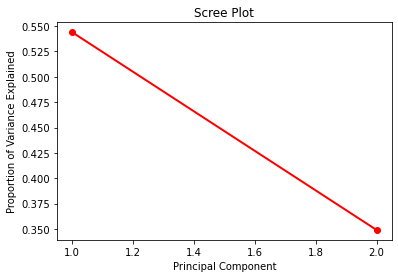

In [55]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

## compute loadings. You'll have to change the columsn and index depending on the number of components and variables you use

In [56]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

#loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=['ALT', 'Subsidence',
#                                                                      'VWC 12', 'VWC 20', 'WTD', 'Elevation', 'Slope',
#                                                                      'Aspect'])
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=['ALT', 'Subsidence','VWC 12', 'VWC 20', 'WTD'])
loading_matrix

,PC1,PC2
ALT,0.787771,-0.352003
Subsidence,0.096868,0.972633
VWC 12,-0.922032,-0.021210
VWC 20,-0.666874,-0.735299
WTD,0.891354,-0.366663


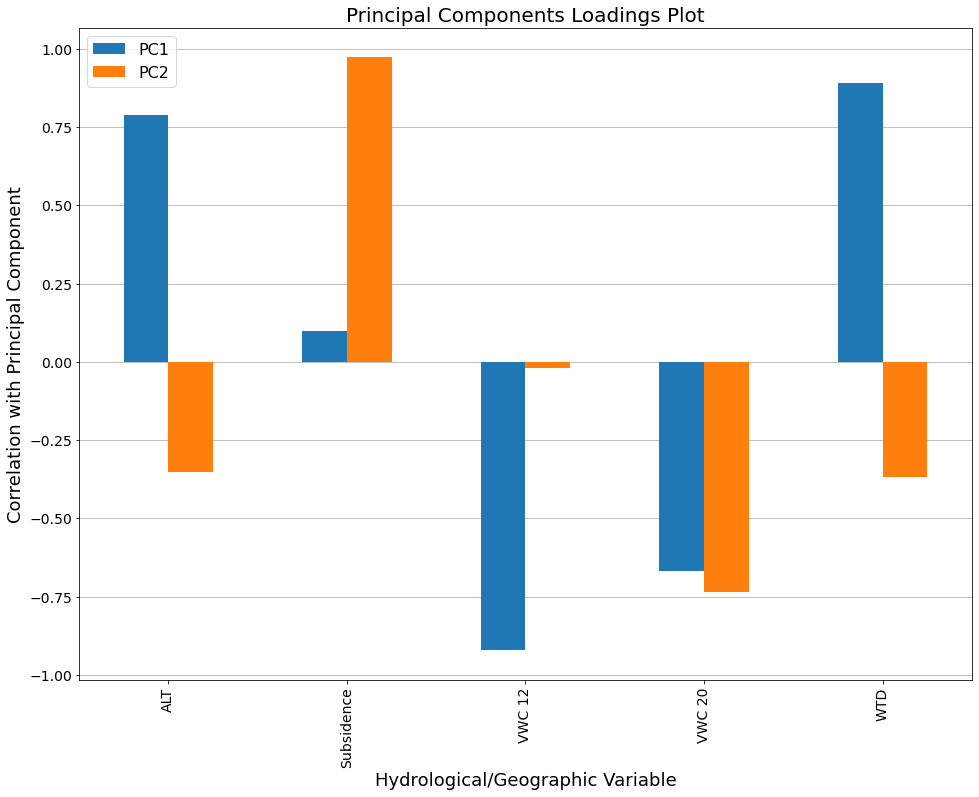

In [58]:
fig, axes = plt.subplots(figsize=(16,12))
loading_matrix.plot.bar(y=[0,1], ax=axes, zorder=2)
axes.set_xlabel('Hydrological/Geographic Variable', fontsize=18)
axes.set_ylabel('Correlation with Principal Component', fontsize=18)
axes.legend(fontsize=16)
axes.tick_params(axis='x', labelsize=14)
axes.tick_params(axis='y', labelsize=14)
axes.set_title('Principal Components Loadings Plot', fontsize=20)
axes.grid(axis='y', zorder=0)

Text(0.5, 1.0, 'Grouping swath points in PCA Space')

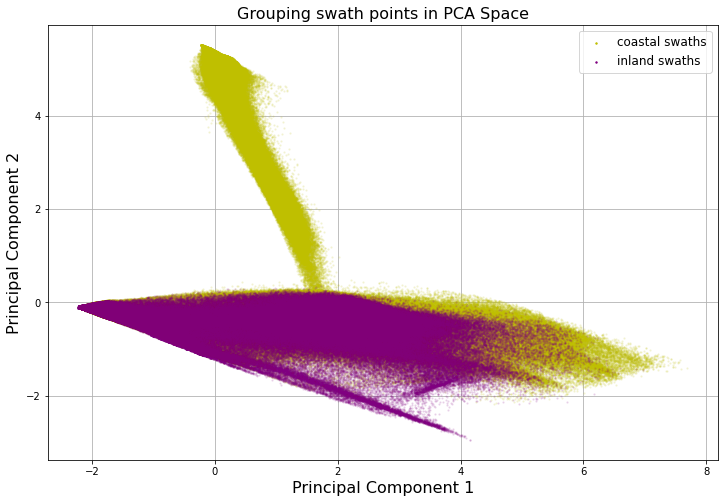

In [59]:
plt.figure(figsize=(12,8))
plt.scatter(pca_out_array[total_group_label==0][:,0], pca_out_array[total_group_label==0][:,1], 
            c='y', alpha=0.1, s=2, zorder=2, label='coastal swaths')
plt.scatter(pca_out_array[total_group_label==1][:,0], pca_out_array[total_group_label==1][:,1],
            c='purple', alpha=0.1, s=2, zorder=4, label='inland swaths')
leg = plt.legend(fontsize=12)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.grid()
plt.xlabel("Principal Component 1", fontsize=16)
plt.ylabel("Principal Component 2", fontsize=16)
plt.title("Grouping swath points in PCA Space", fontsize=16)

## Gaussian mixture clustering (War of the worlds plot)

In [115]:
np.random.shuffle(pca_out_array)
gm = GaussianMixture(n_components=2,
                           max_iter=500, tol=1e-10, covariance_type='full').fit(pca_out_array)
gm_label = gm.predict(pca_out_array)

Text(0.5, 1.0, 'Gaussian Mixture in PCA Space')

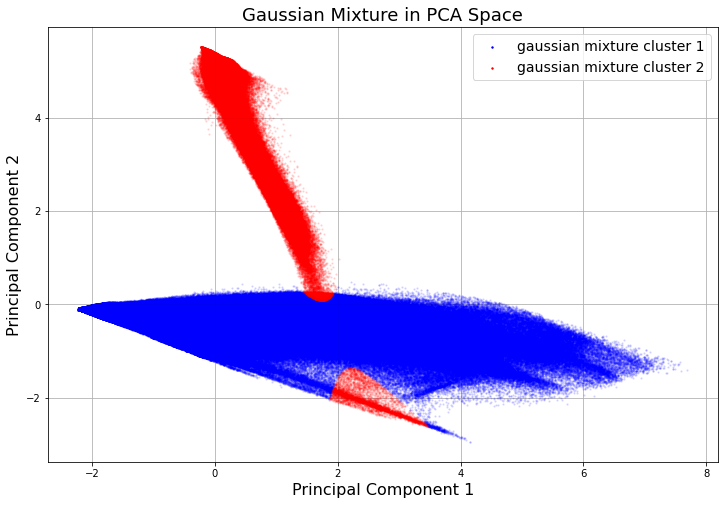

In [116]:
plt.figure(figsize=(12,8))
plt.scatter(pca_out_array[gm_label==0][:,0], pca_out_array[gm_label==0][:,1], 
            c='b', alpha=0.1, s=2, zorder=2, label='gaussian mixture cluster 1')
plt.scatter(pca_out_array[gm_label==1][:,0], pca_out_array[gm_label==1][:,1],
            c='r', alpha=0.1, s=2, zorder=4, label='gaussian mixture cluster 2')
leg = plt.legend(fontsize=14)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.grid()
plt.xlabel("Principal Component 1", fontsize=16)
plt.ylabel("Principal Component 2", fontsize=16)
plt.title("Gaussian Mixture in PCA Space", fontsize=18)

## Plot on Map

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(total_lon[total_group_label==0], total_lat[total_group_label==0], label="Coastal Swath", c='y', 
           alpha=.01, zorder=1, s=1)
ax.scatter(total_lon[total_group_label==1], total_lat[total_group_label==1], label="Inland Swath", c='k', 
           alpha=.01, zorder=2, s=1)
AL_map.boundary.plot(ax=ax) 
ax.set_xlim(-170, -140)
ax.set_ylim(60, 72)
ax.grid(zorder=0)
ax.set_title('Selected Swaths', fontsize=16)
ax.set_xlabel("Longitude", fontsize=16)
ax.set_ylabel("Latitude", fontsize=16)
leg = ax.legend(fontsize=12)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(total_lon[gm_label==0], total_lat[gm_label==0], label="Gaussian mixture cluster 1", c='b', 
           alpha=.01, zorder=1, s=1)
ax.scatter(total_lon[gm_label==1], total_lat[gm_label==1], label="Gaussian mixture cluster 2", c='r', 
           alpha=.01, zorder=2, s=1)
AL_map.boundary.plot(ax=ax)
ax.set_xlim(-170, -140)
ax.set_ylim(60, 72)
ax.grid(zorder=0)
ax.set_title('Gaussian Mixture Clustered Swaths', fontsize=18)
ax.set_xlabel("Longitude", fontsize=16)
ax.set_ylabel("Latitude", fontsize=16)
leg = ax.legend(fontsize=12)
for lh in leg.legendHandles: 
    lh.set_alpha(1)